In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import pipeline

In [38]:
import bz2
import pandas as pd

train_file_path = 'train.ft.txt.bz2'
test_file_path = 'test.ft.txt.bz2'

# Function to read bz2 file line by line
def read_bz2_file(file_path, num_lines=None):
    with bz2.open(file_path, 'rt', encoding='utf-8') as f:
        lines = f.readlines() if num_lines is None else [next(f) for _ in range(num_lines)]
    return lines

# Read the first 10,000 lines for faster processing
train_data = read_bz2_file(train_file_path, num_lines=10000)

# Convert into a Pandas DataFrame
train_df = pd.DataFrame({'raw_text': train_data})

# Extract label and review text
train_df['label'] = train_df['raw_text'].str.extract(r'(__label__\d)')
train_df['text'] = train_df['raw_text'].str.replace(r'__label__\d ', '', regex=True)

# Convert label to readable format
train_df['label'] = train_df['label'].map({'__label__1': 'negative', '__label__2': 'positive'})

# Drop the raw text column
train_df.drop(columns=['raw_text'], inplace=True)

# Display the first few rows
print("Columns in the dataset:", train_df.columns)
print(train_df.head())


Columns in the dataset: Index(['label', 'text'], dtype='object')
      label                                               text
0  positive  Stuning even for the non-gamer: This sound tra...
1  positive  The best soundtrack ever to anything.: I'm rea...
2  positive  Amazing!: This soundtrack is my favorite music...
3  positive  Excellent Soundtrack: I truly like this soundt...
4  positive  Remember, Pull Your Jaw Off The Floor After He...


In [44]:
print("Example line from train.ft.txt:")
print(train_data[:3])
print("Example line from test.ft.txt:")
print(test_data[:5])

Example line from train.ft.txt:
['__label__2 Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^\n', "__label__2 The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny.\n"

In [52]:
import bz2

def process_lines(lines):
    labels = []
    texts = []
    
    for line in lines:
        parts = line.strip().split(' ', 1)  
        if len(parts) == 2: 
            label = parts[0].replace('__label__', '')  
            text = parts[1]
            labels.append(label)
            texts.append(text)
    
    return labels, texts

train_labels, train_texts = process_lines(train_data)
test_labels, test_texts = process_lines(test_data)

print("example from training data:")
print(train_labels[:5])
print(train_texts[:5])

example from training data:
['2', '2', '2', '2', '2']
['Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^', "The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny.", 'A

The code processes the bz2-compressed text files by reading them line by line and extracting the labels and reviews separately. Each line in the file starts with a label (e.g., `__label__2` for positive sentiment or `__label__1` for negative sentiment), followed by the actual review text. The code splits each line into two parts: the label and the text. It then removes the `__label__` prefix from the label and stores both labels and review texts in separate lists. These lists are then converted into a Pandas DataFrame, making it easier to analyze and process the data for tasks like sentiment analysis or machine learning.


In [45]:
label_mapping = {'2': 1, '1': 0}  
train_labels = [label_mapping[label] for label in train_labels]
test_labels = [label_mapping[label] for label in test_labels]

train_df = pd.DataFrame({'label': train_labels, 'text': train_texts})
test_df = pd.DataFrame({'label': test_labels, 'text': test_texts})

print("example from training data:")
print(train_df.head())

KeyError: 1

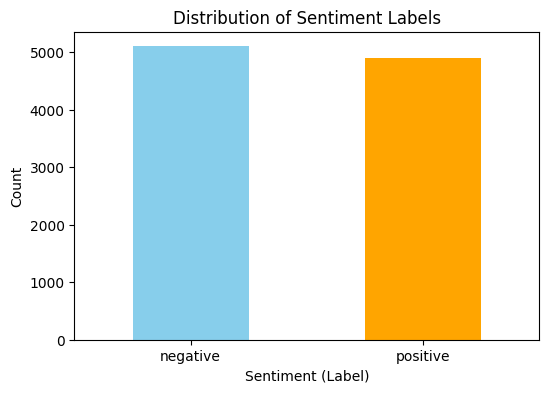

In [53]:
import matplotlib.pyplot as plt

# Replace 0 and 1 with 'negative' and 'positive'
train_df['label'] = train_df['label'].replace({0: 'negative', 1: 'positive'})

# Count the distribution of labels (positive and negative)
label_counts = train_df['label'].value_counts()

# Plot the distribution of labels
plt.figure(figsize=(6, 4))
label_counts.plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment (Label)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


/var/folders/vq/3sqmycf15zx_f11_sby43vx00000gn/T/ipykernel_34961/2810376057.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='review_length', data=train_df, palette="Set2")


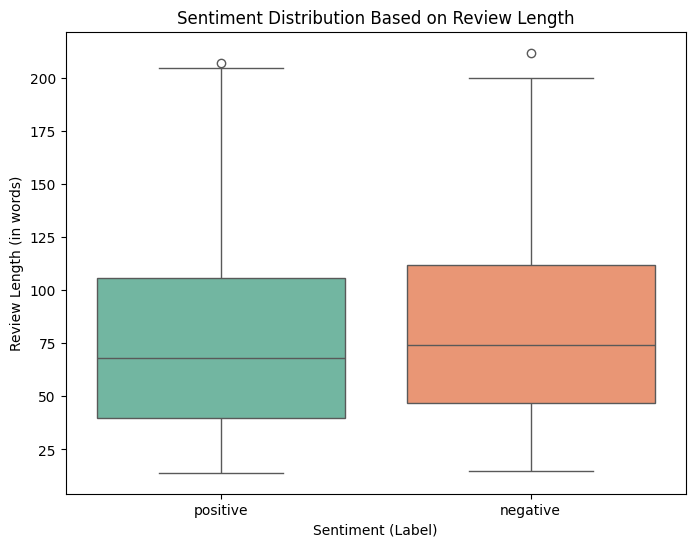

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the length of each review (in words)
train_df['review_length'] = train_df['text'].apply(lambda x: len(x.split()))

# Plot the distribution of review lengths by sentiment using a boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='label', y='review_length', data=train_df, palette="Set2")
plt.title('Sentiment Distribution Based on Review Length')
plt.xlabel('Sentiment (Label)')
plt.ylabel('Review Length (in words)')
plt.show()


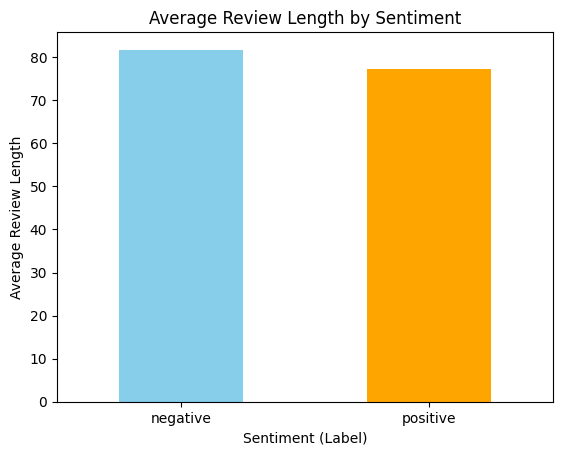

In [22]:
# Calculate the length of each review (in words) based on the 'text' column
train_df['review_length'] = train_df['text'].apply(lambda x: len(x.split()))

# Calculate the average review length per sentiment (label)
average_length = train_df.groupby('label')['review_length'].mean()

# Plot the average review length for each sentiment
average_length.plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Average Review Length by Sentiment')
plt.xlabel('Sentiment (Label)')
plt.ylabel('Average Review Length')
plt.xticks(rotation=0)
plt.show()


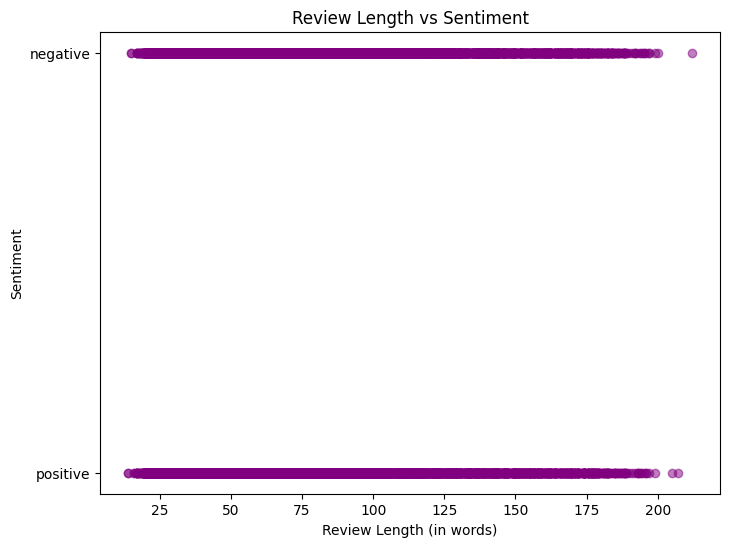

In [29]:
# Scatter plot of review length vs sentiment
plt.figure(figsize=(8, 6))
plt.scatter(train_df['review_length'], train_df['label'], alpha=0.5, color='purple')
plt.title('Review Length vs Sentiment')
plt.xlabel('Review Length (in words)')
plt.ylabel('Sentiment')
plt.show()



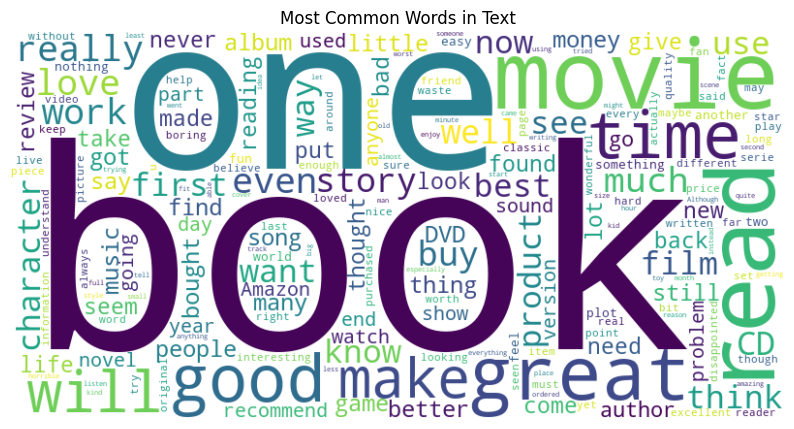

In [35]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all text into a single string
all_reviews = ' '.join(train_df['text'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews)

# Plot the word cloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Text')
plt.show()


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/arijtheweeknd3/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


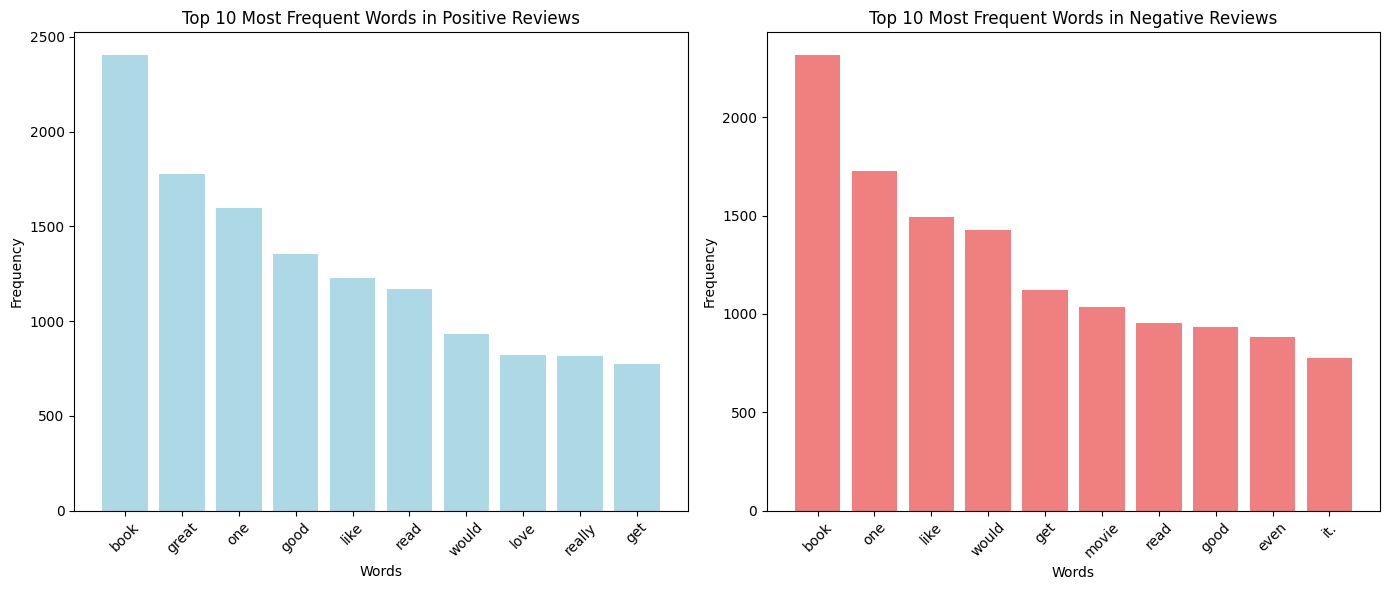

In [32]:
from collections import Counter
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

# visualize the top 10 most frequent words without stopwords 
# Download stopwords if not already present
nltk.download('stopwords')

# Remove stopwords and tokenize the text
stop_words = set(stopwords.words('english'))

# Tokenize the text for both positive and negative labels
positive_reviews_tokens = ' '.join(train_df[train_df['label'] == 'positive']['text']).lower().split()
negative_reviews_tokens = ' '.join(train_df[train_df['label'] == 'negative']['text']).lower().split()

# Filter out stopwords
positive_filtered_words = [word for word in positive_reviews_tokens if word not in stop_words]
negative_filtered_words = [word for word in negative_reviews_tokens if word not in stop_words]

# Get the top 10 most common words for each sentiment
positive_word_freq = Counter(positive_filtered_words).most_common(10)
negative_word_freq = Counter(negative_filtered_words).most_common(10)

# Plot the top 10 most common words for each sentiment
positive_words, positive_counts = zip(*positive_word_freq)
negative_words, negative_counts = zip(*negative_word_freq)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Positive words
axes[0].bar(positive_words, positive_counts, color='lightblue')
axes[0].set_title('Top 10 Most Frequent Words in Positive Reviews')
axes[0].set_xlabel('Words')
axes[0].set_ylabel('Frequency')
axes[0].tick_params(axis='x', rotation=45)

# Negative words
axes[1].bar(negative_words, negative_counts, color='lightcoral')
axes[1].set_title('Top 10 Most Frequent Words in Negative Reviews')
axes[1].set_xlabel('Words')
axes[1].set_ylabel('Frequency')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


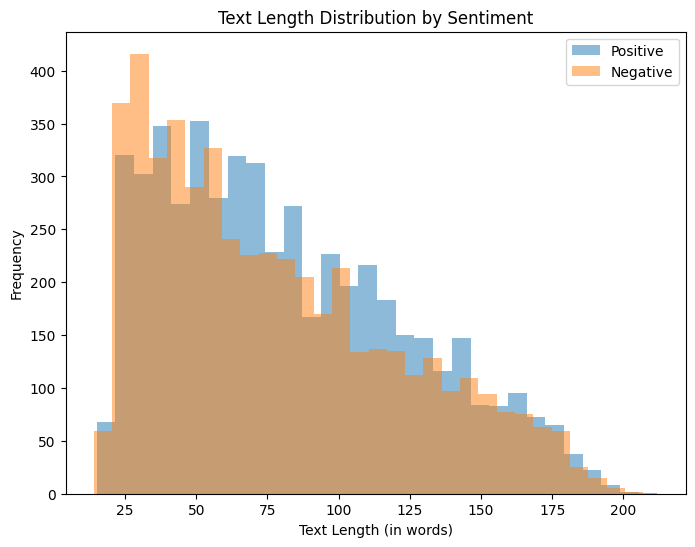

In [37]:
# the relationship between text length and sentiment
train_df['text_length'] = train_df['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 6))
train_df.groupby('label')['text_length'].plot(kind='hist', alpha=0.5, bins=30)
plt.title('Text Length Distribution by Sentiment')
plt.xlabel('Text Length (in words)')
plt.ylabel('Frequency')
plt.legend(['Positive', 'Negative'])
plt.show()
